# Identifying Pulsar Stars Using Integrated and DM-SNR Profiles #
#### Katie Liang and Madilyn Portas ####
***

### INTRODUCTION ###

***

### METHODS AND RESULTS ###

In [1]:
# 1 
# loading libraries
library(tidyverse)
library(tidymodels)
library(dplyr)
library(RColorBrewer)
library(repr)
install.packages('kknn')
library('kknn')
install.packages("plotly")
library(plotly)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
# 2
# load data
url <- "https://raw.githubusercontent.com/madiportas/dsci-100_group_project/main/HTRU_2.csv"
pulsar_raw <- read.csv(url) |>
              rename(ip_mean = integrated_profile_mean,
                     ip_sd = integrated_profile_sd,
                     ip_ek = integrated_profile_ek,
                     ip_s = integrated_profile_s,
                     DM_mean = DM.SNR_curve_mean, 
                     DM_sd = DM.SNR_curve_sd, 
                     DM_ek = DM.SNR_curve_ek,
                     DM_s = DM.SNR_curve_s)

# wrangle data, remove uneeded columns
pulsar <- pulsar_raw |>
    mutate(class = as.factor(class), class = recode(class, "0" = "Not Pulsar", "1" = "Pulsar"))|>
    select(ip_mean, DM_mean, class)|>
    slice(1:1000)

# split data 
set.seed(1)
pulsar_split <- initial_split(pulsar, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

In [3]:
# 3 
# summarize data as part of preliminary data analysis
summary <- group_by(pulsar_train, class) |>
    summarize(
        mean_ip = mean(ip_mean),
        max_ip = max(ip_mean), 
        min_ip = min(ip_mean), 
        mean_DM = mean(DM_mean),
        max_DM = max(DM_mean), 
        min_DM = min(DM_mean))
summary

class,mean_ip,max_ip,min_ip,mean_DM,max_DM,min_DM
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Not Pulsar,116.98682,163.7969,59.35156,6.273965,211.9490,0.3871237
Pulsar,58.50586,123.4688,11.21875,42.918816,176.1196,0.9581940


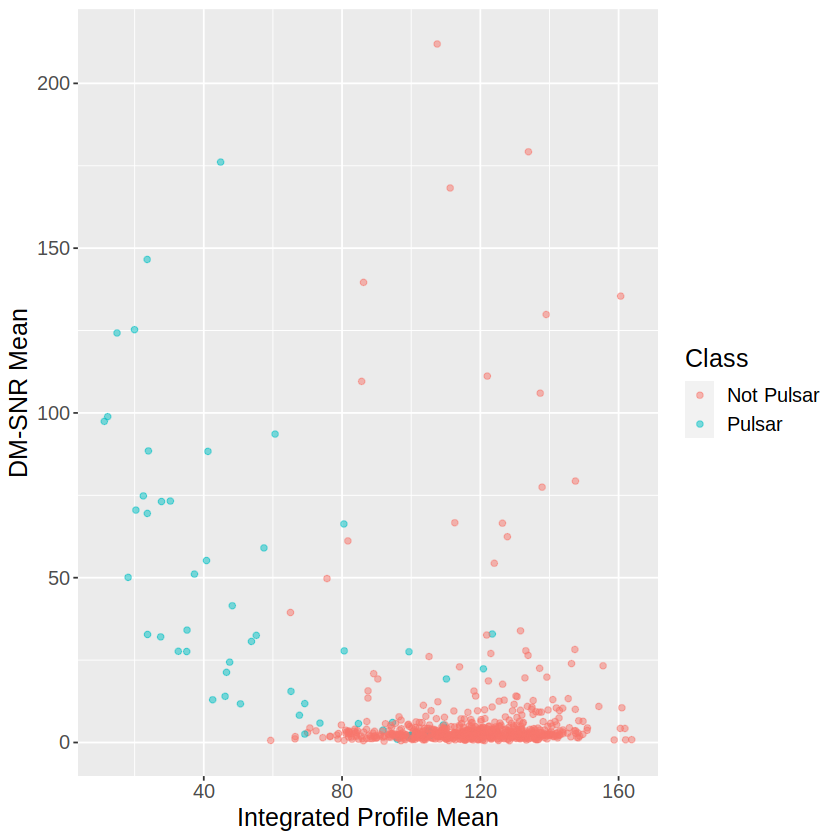

In [38]:
# 4 
# visualize data as part of preliminary data analysis
pulsar_plot <- ggplot(pulsar_train, aes(x = ip_mean, y = DM_mean, color = class)) +
        geom_point(alpha = 0.5) +
        labs (x = "Integrated Profile Mean", y = "DM-SNR Mean", color = "Class") + 
        theme(text = element_text(size = 15)) 
pulsar_plot

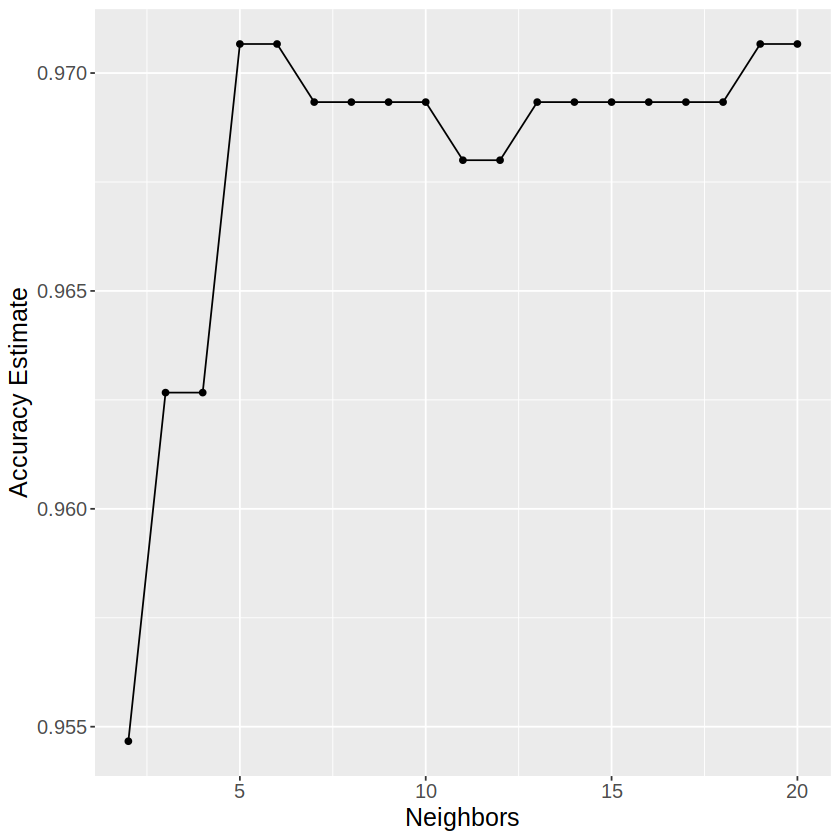

In [39]:
# 5 
# KNN classification prep, determination of K
set.seed(1)
pulsar_recipe <- recipe(class ~ ip_mean + DM_mean, data = pulsar_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
pulsar_vfold <- vfold_cv(pulsar_train, v = 10, strata = class)
pulsar_fit <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(pulsar_spec) |>
    tune_grid(resamples = pulsar_vfold, grid = tibble(neighbors = c(2:20))) |>
    collect_metrics()
pulsar_accuracies <- pulsar_fit |>
    filter(.metric == 'accuracy')
pulsar_cross_valid <- ggplot(pulsar_accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 15)) 
pulsar_cross_valid

In [6]:
# 6 
# train workflow with training data 
set.seed(1)
pulsar_recipe <- recipe(class ~ ip_mean + DM_mean, data = pulsar_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")
pulsar_fit <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(pulsar_spec) |>
    fit(data = pulsar_train)
pulsar_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.028
Best kernel: rectangular
Best k: 5

In [14]:
# 7 
# predict with testing data 
set.seed(1)
pulsar_predictions <- predict(pulsar_fit, pulsar_test) |>
    bind_cols(pulsar_test)
pulsar_metrics <- pulsar_predictions |> metrics(truth = class, estimate = .pred_class)
pulsar_conf_mat <- pulsar_predictions |>
    conf_mat(truth = class, estimate = .pred_class) 
pulsar_metrics
pulsar_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9680000
kap,binary,0.8087954


            Truth
Prediction   Not Pulsar Pulsar
  Not Pulsar        223      7
  Pulsar              1     19

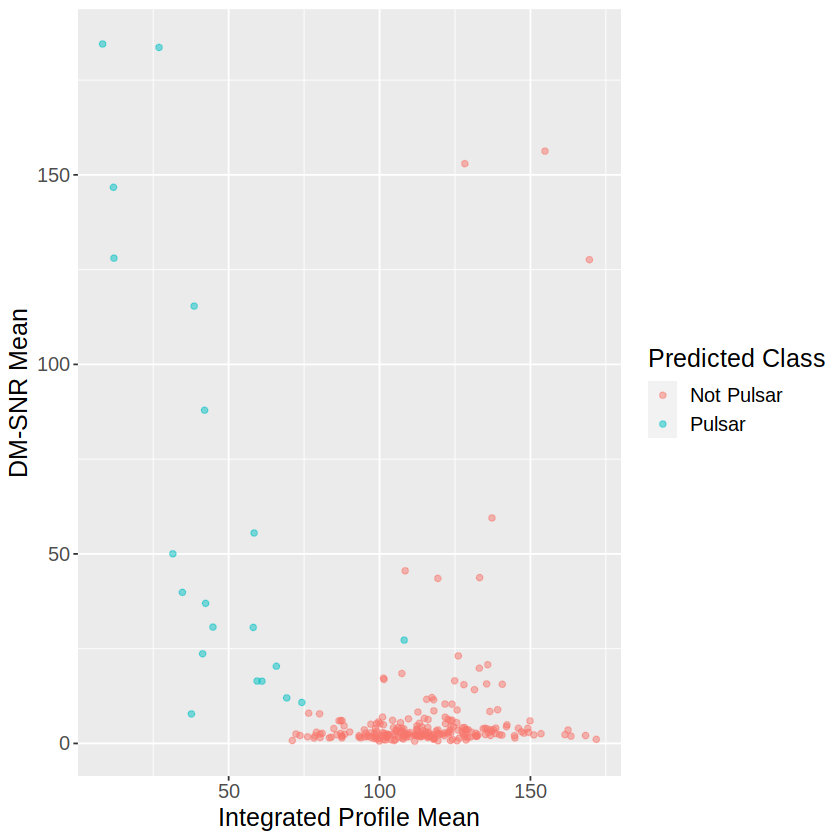

In [40]:
# 8 
# visualize results 
pulsar_visualize <- ggplot(pulsar_predictions, aes(x = ip_mean, y = DM_mean, color = .pred_class)) + 
    geom_point(alpha = 0.5) +
    labs (x = "Integrated Profile Mean", y = "DM-SNR Mean", color = "Predicted Class") + 
    theme(text = element_text(size = 15)) 
pulsar_visualize

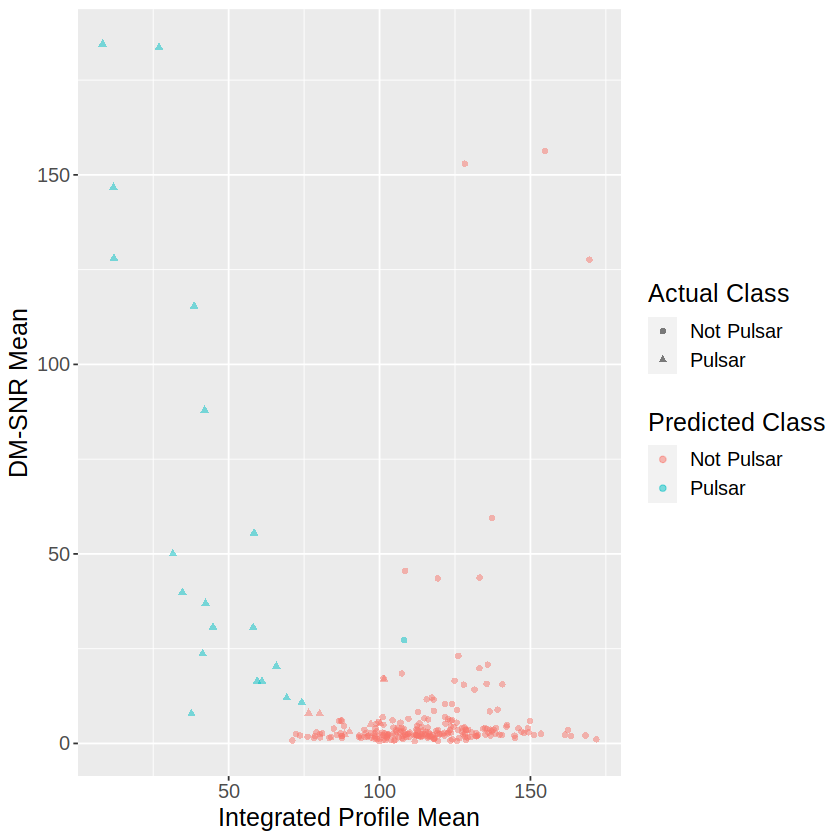

In [41]:
# 9 
# visualize confusion matrix
pulsar_confusion <- pulsar_predictions |>
    select(.pred_class) |>
    bind_cols(pulsar_test |> select(class, ip_mean, DM_mean)) |>
    as.data.frame()
pulsar_visualize_confusion <- ggplot(pulsar_confusion, aes(x = ip_mean, y = DM_mean, shape = class, color = .pred_class)) + 
    geom_point(alpha = 0.5) +
    labs (x = "Integrated Profile Mean", y = "DM-SNR Mean", color = "Predicted Class", shape = "Actual Class") + 
    theme(text = element_text(size = 15)) 
pulsar_visualize_confusion

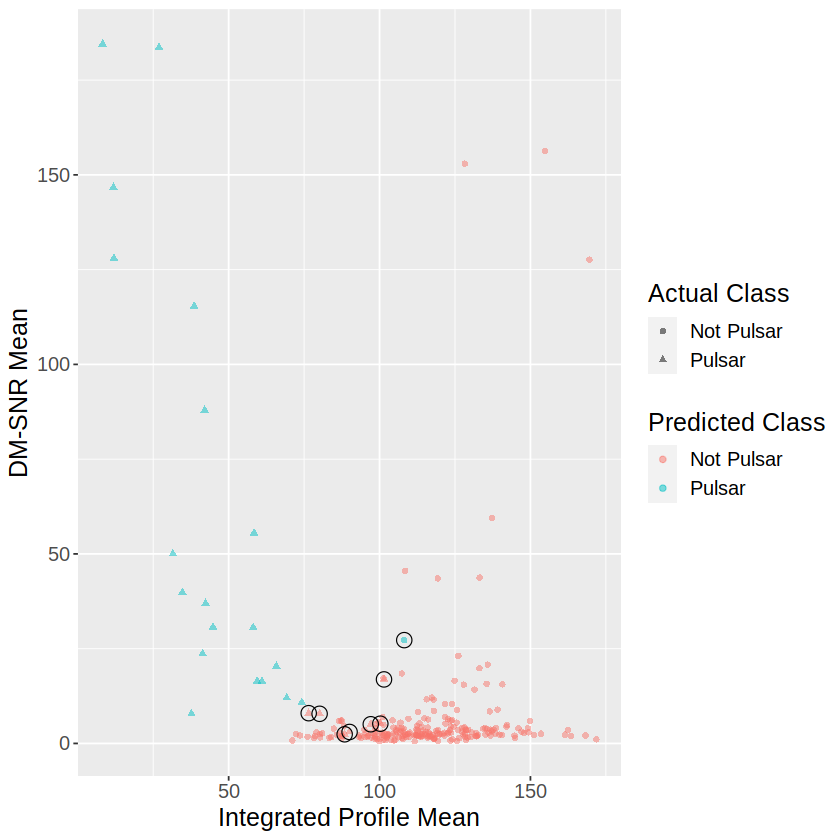

In [42]:
# 10 
# finding areas of weakness in the model 
pulsar_visualize_confusion_circled <- ggplot(pulsar_confusion, aes(x = ip_mean, y = DM_mean, shape = class, color = .pred_class)) + 
    geom_point(alpha = 0.5) +
    labs (x = "Integrated Profile Mean", y = "DM-SNR Mean", color = "Predicted Class", shape = "Actual Class") + 
    geom_point(data=pulsar_confusion |> filter(.pred_class != class), 
           pch=21, 
           size=4, 
           colour="black") + 
    theme(text = element_text(size = 15)) 
pulsar_visualize_confusion_circled

***

### DISCUSSION ###

***

### REFERENCES ###

***